# **Questão de 'negócio'**

A Biblioteca do IFTM - Campus Paracatu possui um histórico de emprestimos com mais de 7 anos. Tais dados, nunca foram analisados para verificar se existem informações úteis para a gestão da biblioteca e/ou melhorias nos processos adotados pelo setor.

Dessa forma, esse trabalho se utiliza das técnicas de Data Science para identificar quais insighs podem ser conseguidos através dos dados de emprestimo entre os anos de 2015 e 2019. Também foram elaboradas algumas hipóteses para serem validadas/refutadas.

Questão de negócio: **De que modo os processos adotados atualmente no setor afetam a quantidade de empréstmios realizadas?**

# **Entendimento de negócio**

A Biblioteca é um espaço público, dentro do campus do IFTM em Paracatu. 
Os empréstimos são feitos durante os períodos de funcionamento do setor (das 07h às 22h30min) de segunda à sexta.
Os usuários aptos para empréstimos são os alunos e servidores ( a comunidade externa não pode realizar empréstimos).

Os empréstimos são geridos pelo sistema GNUTECA (de onde os dados foram coletados).

**Nesse sentido, as questões a serem verificadas são:**

    - O número médio de empréstimos realizados é considerado abaixo, acima ou na média?
    - Quais insights podem ser adquiridos dos dados de empréstimo?

### **Entregas**

    - Relatórios com as hipóteses avaliadas (Hospedado no heroku)
    - Tabela com os insights conseguidos através dos dados


### **Ferramentas**

*   Python
*   Jupyter Notebook

### **Processos**

* Negócios
    1 Elaborar as hipóteses

* Coleta dos dados
    2 Fazer o download do .csv no GNUTECA;

* Limpeza dos dados
    - Retirar os empréstimos que não tenham sido feitos entre 2015 e 2019;
    - Retirar os empréstimos em atraso;
    - Corrigir datas e eventuais dados faltantes;
    - Retirar/modificar dados que ajudem na análise das hipóteses;
    
* Exploração dos dados
    - Análise das hipóteses
    - Buscar insights
* Apresentação
    - Criar os slides de apresentação
    - Marcar uma reunião para apresentar os resultados
    

# Imports

In [32]:
# Imports

from datetime import datetime
import pandas as pd
import numpy as np
import locale
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
pd.options.plotting.backend = "matplotlib"
import plotly.express as px
import csv
import gzip
import io

from unicodedata          import normalize
from IPython.core.display import display, HTML

# Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
   #pd.options.display.max_rows = None
    #pd.set_option('display.expand_frame_repr', False)
    sns.set()
jupyter_settings()

def calcula_taxa(x):
    tx_anual = [1, 2, 3, 4]

    for i in range(0, len(x)):
        if i < 4:
            tx_anual[i] = round((x[i+1] - x[i])/x[i], 2)

    return tx_anual

def zera_multa(x):
    x = 0
    return x


def verifica_cdd(classificacao):
    return classificacao


def load_data():
    fobj = io.TextIOWrapper(gzip.open("../src/nomes.csv.gz"), encoding="utf-8")
    csv_reader = csv.DictReader(fobj)
    data = {
        row["first_name"]: row["classification"]
        for row in csv_reader
    }
    fobj.close()
    return data


def classifica_nome(name):
    encoded_name = encode(name)
    if encoded_name in name_data:
        return name_data[encoded_name]
    else:
        return "Nulo"


def encode(name):
    ascii_name = normalize("NFKD", name).encode(
        "ascii", errors="ignore").decode("ascii")
    return ascii_name.upper()


# **Coleta de Dados**

In [3]:
# Load data
data = pd.read_csv('../datasets/raw/emprestimo-bib-ptu.csv', sep=";")


# **Limpeza de dados**

## Clear data

        - Retira os Empréstimos atrasados
        - Retira os dados Pendentes
        - Retira os Emprestimos de chaves
        - Modifica o tipo dos campos Data
        - Retira/substitui os valores faltantes

In [4]:
# Converte os campos de data para datetime
data['Data de empréstimo'] = data['Data de empréstimo'].map(lambda x: datetime.strptime(x, "%d/%m/%Y"))
data['Data de devolução'] = data['Data de devolução'].map(lambda x: datetime.strptime(x, "%d/%m/%Y"))

In [5]:
# Retira os atrasados e os pendentes para modificar a data de devolução

data = data.loc[data['Estado_do_emprestimo'] != 'ATRASADO']
data = data.loc[data['Estado_do_emprestimo'] != 'PENDENTE']

In [6]:
# Converte o campo de data de devolução para datetime

data['Data de devolução.1'] = data['Data de devolução.1'].map(
    lambda x: datetime.strptime(x, "%d/%m/%Y"))

In [7]:
# Retira os empréstimos de chaves

data = data.loc[(data['Título'] != 'Chaves das Salas de Estudo') & (
    data['Título'] != 'Chaves dos escaninhos')]

In [8]:
# Substitiu os dados faltantes
data = data.fillna("Nenhum")

## Transformações 

In [9]:
# DF1 - Data frame para Feature Engineering
df1 = data.copy()

In [10]:
# Altera os nomes das colunas

df1.columns = ['num_controle', 'tombo', 'cod_pessoa', 'nome_pessoa', 'titulo', 'autor',
               'classificacao', 'data_emprestimo', 'data_prevista_devolucao', 'data_devolucao', 'estado_emprestimo']

## Feature Engineer

* Decompor as datas
* Deriva dias de emprestimo e de atraso das datas
* Deriva valor de multas emitidas
* Deriva o sexo dos nomes
* Deriva a classifação CDD a partir do numero de classificação

In [11]:
# Decompondo as datas
df1['ano'] = df1['data_emprestimo'].dt.year
df1['mes'] = df1['data_emprestimo'].dt.month
df1['dia'] = df1['data_emprestimo'].dt.day

In [12]:
# Deriva dias de emprestimo e de atraso das datas
df1['dias_de_emprestimo'] = df1.apply(lambda x: (
    x['data_devolucao'] - x['data_emprestimo']).days, axis=1)

df1['dias_de_atraso'] = df1.apply(lambda x:
    zera_multa(x) if x['data_devolucao'] <  x['data_prevista_devolucao'] else
    (x['data_devolucao'] - x['data_prevista_devolucao']).days, axis=1)

In [13]:
# Calcula o valor das multas
valor_multa = 0.5
df1['valor_multa'] = df1.apply(lambda x: x['dias_de_atraso'] * valor_multa, axis=1)

## Analise descritiva

In [14]:
# DF2 - Para análise descritiva
df2 = df1.copy()

In [15]:
# retira os anos antes de 2015 e após 2019
df2 = df2.loc[(df2['ano'] > 2014) & (df2['ano'] < 2020)]

### Variáveis numéricas

### Variáveis categóricas

# **Exploração de dados**

>Informações sobre os dados

* Os dados foram coletados do GNUTECA no dia 21/06/2021
* Estão sendo considerados o intervalo entre 2015 e 2019
* Foram retirados os empréstimos:
    - ATRASADOS
    - PENDENTES
    - CHAVES DE ESCANINHO E SALAS DE ESTUDO

In [16]:
t_emprestimo = len(df2)
t_usuario_unicos = len(df2.cod_pessoa.unique())
t_valor_pago_multa = df2.valor_multa.sum()
t_livros_unicos = len(df2.tombo.unique())

data = {'Total de Emprestimo': [t_emprestimo], 'Usuários únicos': [
    t_usuario_unicos], 'Valor pago de multas': t_valor_pago_multa, 'Livros únicos': t_livros_unicos}

descricao = pd.DataFrame(data=data)

In [17]:
# DF3 - Análise de hipoteses sobre os dados
df3 = df2.copy()

### Hipóteses 

In [18]:
total_emprestimos = df3.count().tombo
total_multa = df3.valor_multa.sum()
anos_estudados = '2015 - 2016 - 2017 - 2018 - 2019'

####     h1 - A quantidade de empréstimos aumentou em média 15% ano;

<font color=red> **FALSO:** Os empréstimos aumentaram em média <b>8,4%</b> no período, sendo que nos anos 2018 e 2019 houve uma queda de 21%.</font>

In [111]:
# Função de changed - Calcula variação em um período
# Calcular os emprestimo por ano
#    - Verificar a variação anual em percentagem

por_ano = pd.DataFrame(df3.groupby('ano').tombo.count())
por_ano['mudanca'] = 100 * por_ano.pct_change()
por_ano = por_ano[por_ano.index>2015].reset_index()

fig = px.bar(por_ano, x='ano', y='mudanca', range_color=[2017,2019], labels={'mudanca':' % variação '})
fig.show()

print("** Os emprestimos aumentaram na média {:.2}% entre os anos de 2015 e 2019 **".format(por_ano.mudanca.mean()))

** Os emprestimos aumentaram na média 8.4% entre os anos de 2015 e 2019 **


In [75]:
# Grafico de emprestimos por ano
aux1 = df3.groupby('ano').count().reset_index()

fig = px.bar(aux1, x='ano', y='tombo', title="Gráfico de empréstimos por ano", labels={
             'tombo': 'Quantidade de empréstimos'}, color='ano', range_color=[2015, 2020])
fig.show()

#### h2 - Os livros de literatura representam 25% do total de empréstimos no período


<font color=red> **FALSO:** Os empréstimos de livros de literatura representam <b>18.64%</b> do total de empréstimos no período.</font>

In [76]:
total_emprestimos_literatura = df3.loc[df3['classificacao'].str.startswith(
    "8")].count().unique()

percentual = round((total_emprestimos_literatura[0] / len(df3)) * 100, 2)

print(
    "**Os empréstimos de livros de literatura representam {}% do total de empréstimos no período **"
    .format(percentual))

**Os empréstimos de livros de literatura representam 18.64% do total de empréstimos no período **


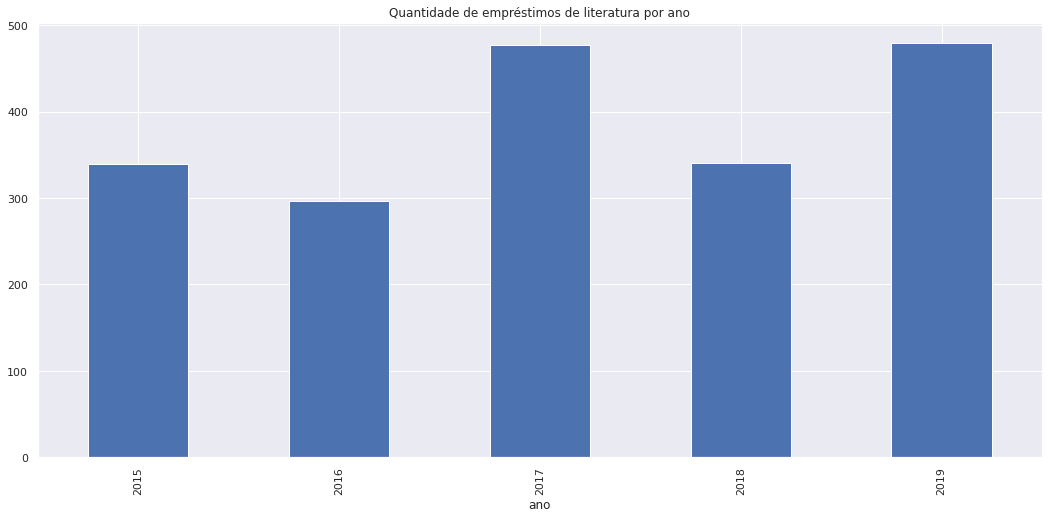

In [77]:
emprestimos_literatura = df3.loc[df3['classificacao'].str.startswith("8")]
emprestimos_literatura.groupby('ano').tombo.count().plot.bar(
    figsize=[18, 8], title="Quantidade de empréstimos de literatura por ano")
print('')

#### h3 - Um usuário fica em média 10 dias com o livro emprestado;

<font color=red> **FALSO:** Um empréstimo dura em média <b>20 dias</b>;.</font><br><br>
<font color=bronw> **OBSERVAÇÃO:** Devido a alta dispersão dos dados, a média central que ajuda entender melhor os dados seria a mediana. Nesse caso, o valor da mediana no período foi de <b>14 dias</b>;.</font>

In [78]:
# calcula dias a média dos dias de empréstimo
dias_de_emprestimo_mean = round(df3.dias_de_emprestimo.mean(),1)
dias_de_emprestimo_median = round(df3.dias_de_emprestimo.median(),1)
dias_de_emprestimo_mode = round(df3.dias_de_emprestimo.mode(),1)

print('Os usuários ficaram em média {} dias com os livros emprestados.'.format(dias_de_emprestimo_mean))
print('A media dos empréstimo é de {} dias.'.format(dias_de_emprestimo_median))
print('A moda dos empréstimo é de {} dias.'.format(dias_de_emprestimo_mode[0]))

Os usuários ficaram em média 19.9 dias com os livros emprestados.
A media dos empréstimo é de 14.0 dias.
A moda dos empréstimo é de 10 dias.


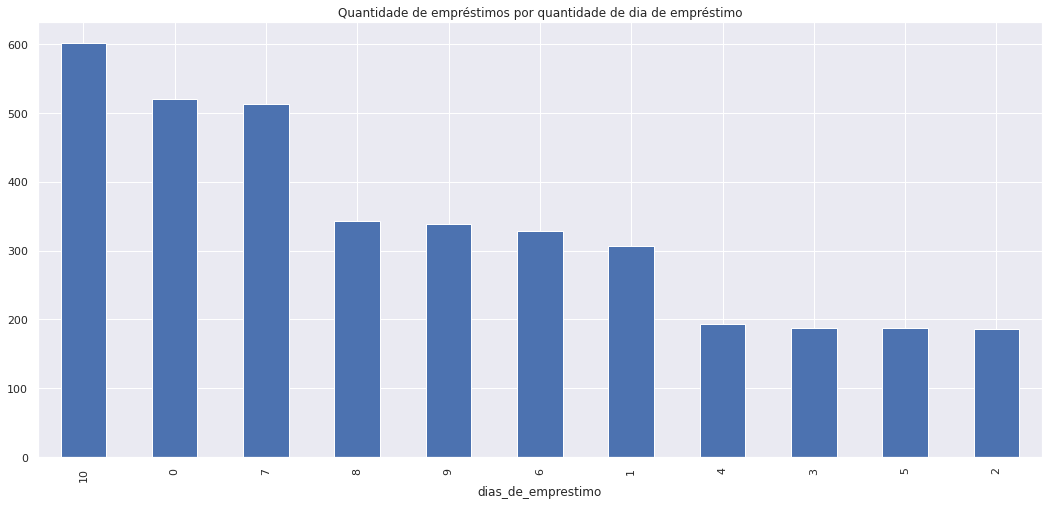

In [79]:
# Dias de empréstimo n
df_por_dia = df3.groupby('dias_de_emprestimo').count().sort_values(
    by='dias_de_emprestimo')
df_por_dia.iloc[0:11].tombo.sort_values(ascending=False).plot.bar(
    figsize=[18, 8],
    title="Quantidade de empréstimos por quantidade de dia de empréstimo")
print('')

#### h4 - Mais de 10% dos livros emprestados são devolvidos com atraso;

<font color=green> **VERDADEIRO:** No período, <b>24%</b> dos livros foram devolvidos com atraso;.</font><br>

In [80]:
# Verifica a quantidade de livros por estado do empréstimo

df3.groupby('estado_emprestimo').count()
total_devolvido_com_atraso = df3.loc[df3['estado_emprestimo']
                                               == 'DEVOLVIDO COM ATRASO'].count().unique()

percentual_com_atraso = round((total_devolvido_com_atraso[0] / len(df3)),2)*100

print("** O percentual de livros devolvidos com atraso é de {:}%. **".format(percentual_com_atraso))

** O percentual de livros devolvidos com atraso é de 24.0%. **


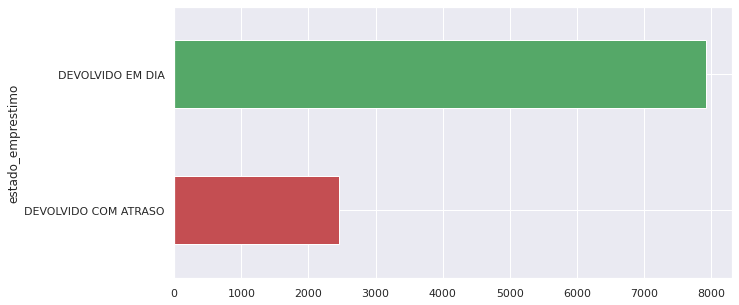

In [81]:
df3.groupby('estado_emprestimo').tombo.count().plot.barh(figsize=[10,5], color=['r','g'])
print('')

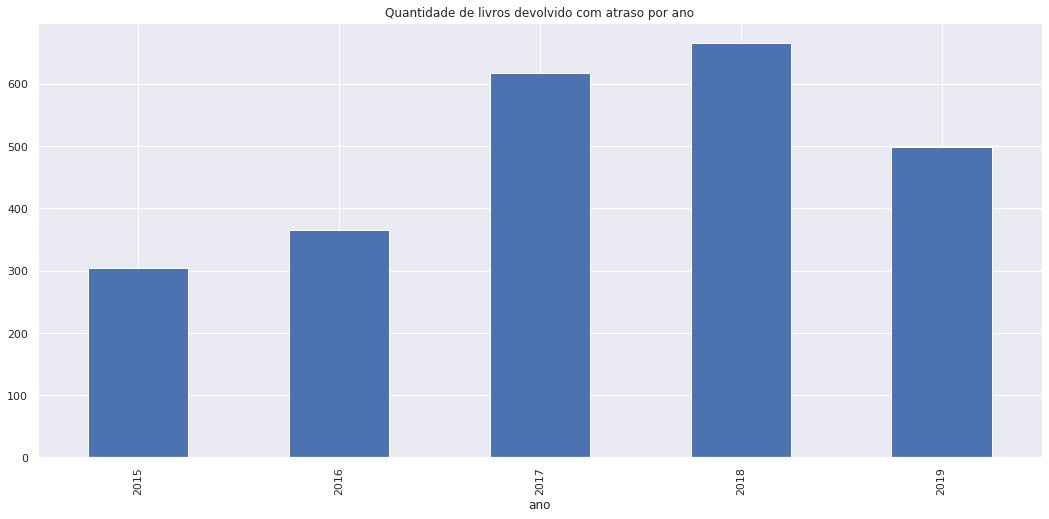

In [82]:
df_devolvidos_com_atraso = df3.loc[df3['estado_emprestimo'] ==
                                   'DEVOLVIDO COM ATRASO']

df_devolvidos_com_atraso.groupby('ano').dias_de_emprestimo.count().plot.bar(
    figsize=[18, 8], title='Quantidade de livros devolvido com atraso por ano')
print('')

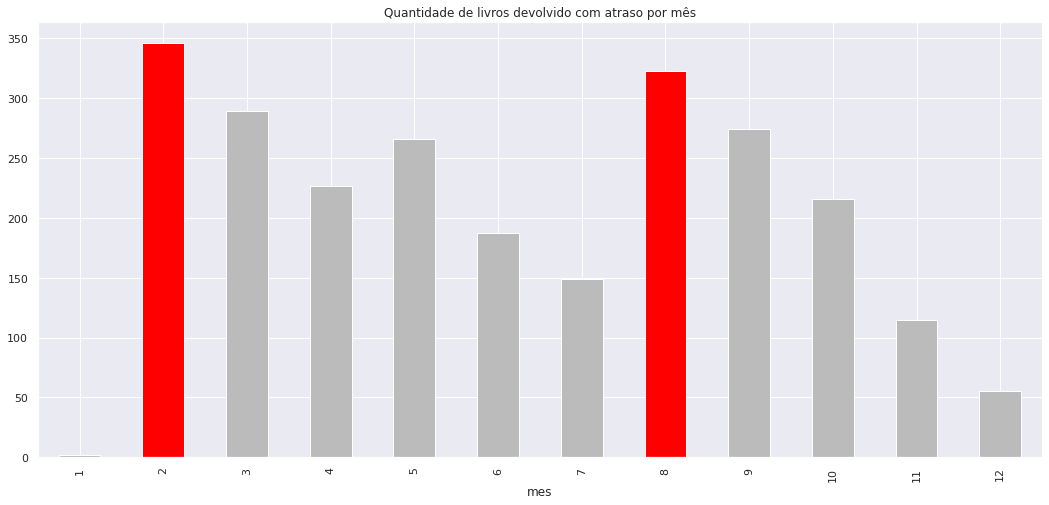

In [83]:
df_devolvidos_com_atraso.groupby('mes').dias_de_emprestimo.count().plot.bar(
    figsize=[18, 8],
    color=[
        '#bbb', 'red', '#bbb', '#bbb', '#bbb', '#bbb', '#bbb', 'red', '#bbb',
        '#bbb', '#bbb', '#bbb'
    ],
    title='Quantidade de livros devolvido com atraso por mês')
print('')

/home/nataniel/anaconda3/envs/analysis/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



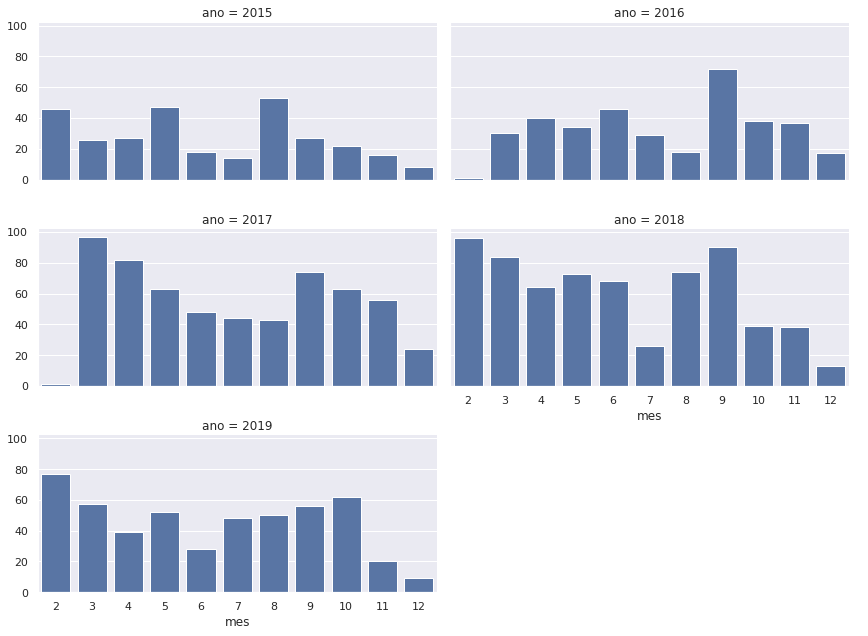

In [84]:
g = sns.FacetGrid(df_devolvidos_com_atraso, col='ano', col_wrap=2, aspect=2)
g.map(sns.countplot,'mes')
g.add_legend()
print('')

#### h5 - Usuários do sexo feminino pegam 30% MAIS livros que os usuários masculinos;

<font color=red> **FALSO:** Usuários do sexo feminino pegam <B>23,5% MENOS</B> livros que os usuários masculinos;.</font><br>

In [85]:
df4 = df3.copy()

In [86]:
# Cria uma feature com o primeiro nome
df4['primeiro_nome'] = df4['nome_pessoa'].map(lambda x: x.strip().split(' ')[0])

# Cria a variável com os nomes do IBGE para verificar o sexo
name_data = load_data()

# Cria a variável sexo através da função de classficação
df4['sexo'] = df4['primeiro_nome'].apply(classifica_nome)

# Deleta a variavel auxiliar com o primeiro nome
df4.drop(columns=['primeiro_nome'], inplace=True)

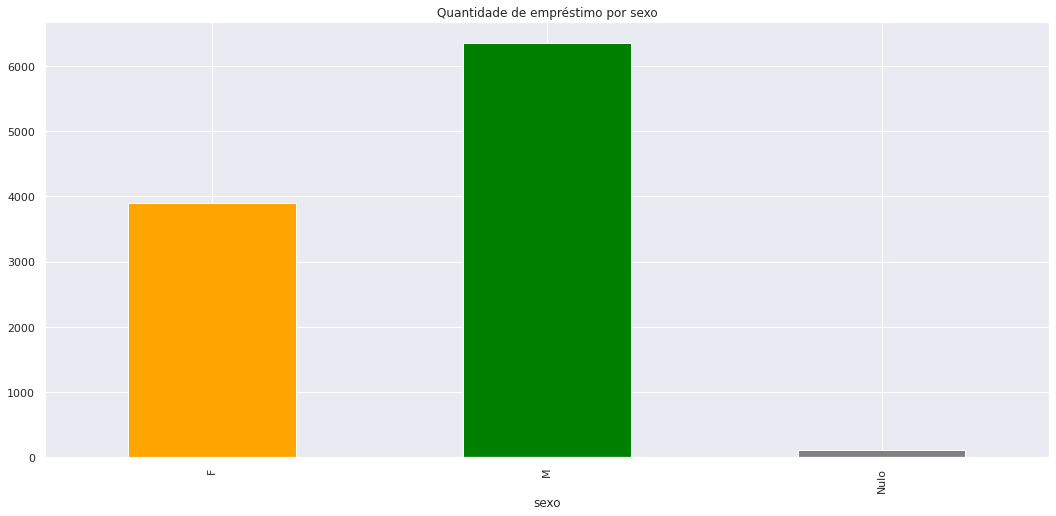

In [87]:
# Quantidade de empreśtimos totais por sexo
df4.groupby('sexo').tombo.count().plot.bar(
    figsize=[18, 8],
    color=['orange', 'green', 'gray'],
    title='Quantidade de empréstimo por sexo')
print('')

In [88]:
total_emp_feminino =  df4.loc[df4['sexo'] == 'F'].count().unique()
total_emp_masculino =  df4.loc[df4['sexo'] == 'M'].count().unique()
total_emp_nulo =  df4.loc[df4['sexo'] == 'Nulo'].count().unique()

tx_emp_feminino = total_emp_feminino / len(df4) * 100
tx_emp_masculino = total_emp_masculino / len(df4) * 100

In [89]:
print('O total de emprestimo feminino foi de: {}.'.format(
    total_emp_feminino[0]))
print('O total de emprestimo masculino foi de: {}.'.format(
    total_emp_masculino[0]))
print('O total de emprestimo nulo foi de: {}.'.format(total_emp_nulo[0]))

print('\nOs empréstimo feito por usuários do sexo feminino representam {:.2f}% do total de empreśtimos.'.format(
    tx_emp_feminino[0]))

print('Os empréstimo feito por usuários do sexo masculino representam {:.2f}% do total de empreśtimos.'.format(
    tx_emp_masculino[0]))

O total de emprestimo feminino foi de: 3905.
O total de emprestimo masculino foi de: 6349.
O total de emprestimo nulo foi de: 110.

Os empréstimo feito por usuários do sexo feminino representam 37.68% do total de empreśtimos.
Os empréstimo feito por usuários do sexo masculino representam 61.26% do total de empreśtimos.


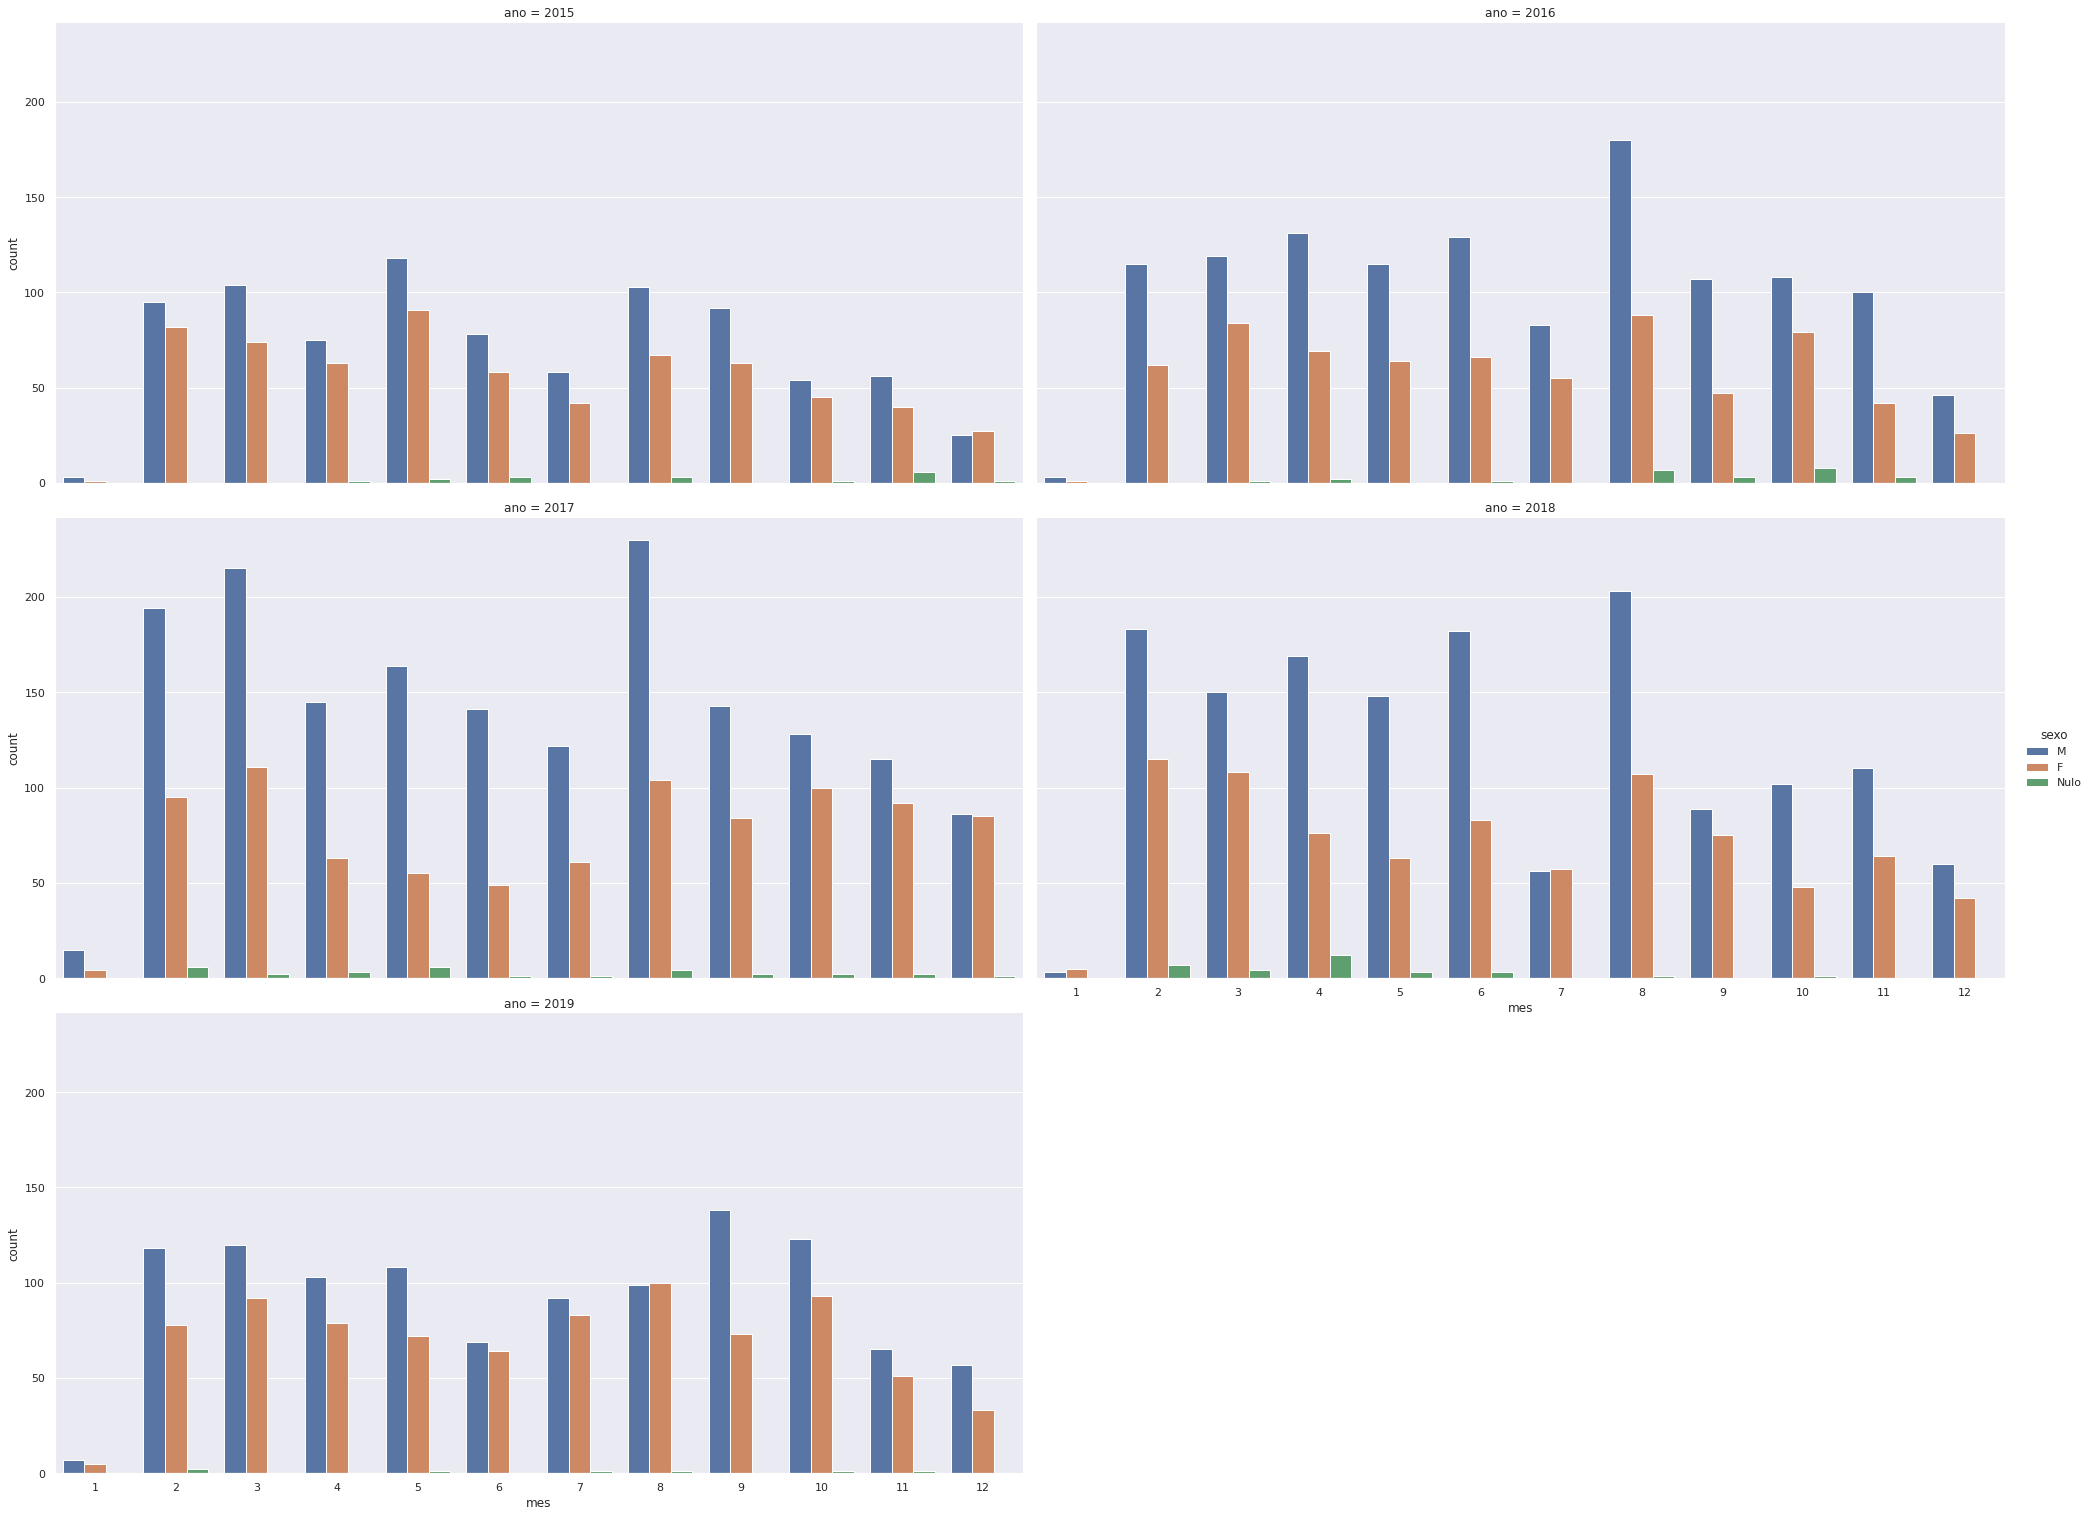

In [90]:
g = sns.catplot(x='mes',hue='sexo', col='ano', data=df4, kind='count', col_wrap=2, height=7,aspect=2)

#### h6 - Os livros de Ciências Sociais (Pedagógicos) representam menos de 5% do total de empréstimos;

<font color=green> **VERDADEIRO:** Os livros de Ciências Sociais (Pedagógicos) representam 4% do total de empréstimos;</font><br>

In [91]:
df5 = df4.copy()

In [92]:
# Filtrar os livrso que começam com a classificação 3
# - Faze a contagem
# - Calcular a pocentagem em relação a quantidade total de empréstimos

total_emp_pedagogico = df5.loc[df5['classificacao'].str.startswith(
    '3')].count().unique()

tx_emp_pedagogicos = round(total_emp_pedagogico[0] / len(df5),2) * 100

print('Total de emprestimos com classificação em Ciencias Sociais: {}.'.format(total_emp_pedagogico[0]))
print('Os emprestimos de livros pedagógicos representam {}% do total.'.format(tx_emp_pedagogicos))


Total de emprestimos com classificação em Ciencias Sociais: 403.
Os emprestimos de livros pedagógicos representam 4.0% do total.


#### h7 - Em média 20% do acervo fica emprestado anualmente;

<font color=red> **FALSO:** Em média 41,25% do acervo fica emprestado anualmente.</font><br>
<font color=red> **OBSERVAÇÃO:** Esse valor considera o mesmo valor de livros ano a ano.</font><br>

In [93]:
df6 = df5.copy()

In [94]:
# Assumindo que a quantidade livros atuais do acervo seja de 5025 exemplares (informação extraído do sistema)
# O valor do acervo modifica-se ano a ano

TOTAL_LIVROS = 5025

 Em média 41.25% do acervo fica emprestado anualmente.



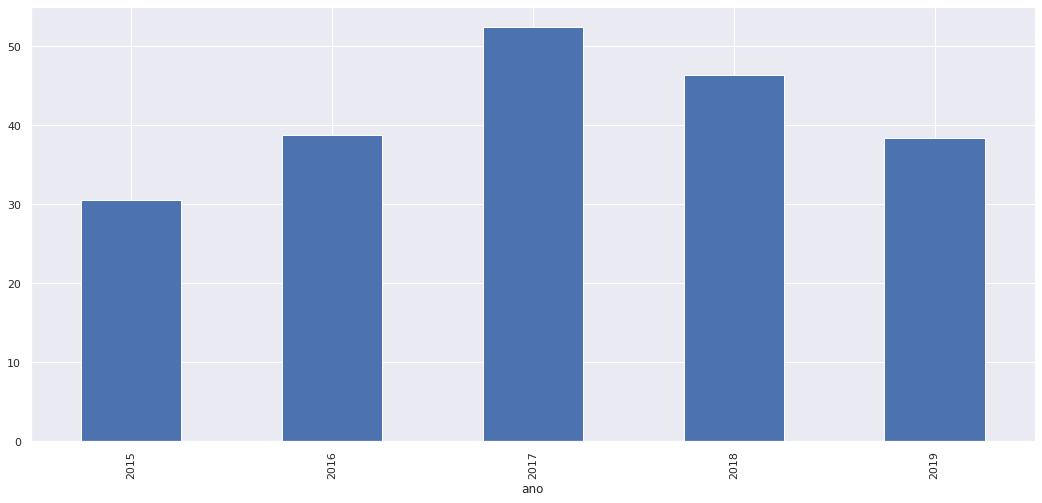

In [95]:
# calcula percentual anual emprestado em relação ao acervo

df_tx_emp_por_ano = pd.DataFrame(df6.groupby('ano').tombo.count())

df_tx_emp_por_ano['% anual em relação ao acervo'] = df_tx_emp_por_ano.apply(
    lambda x: (x/TOTAL_LIVROS)*100)

media = round(df_tx_emp_por_ano['% anual em relação ao acervo'].mean(),2)

print(' Em média {}% do acervo fica emprestado anualmente.'.format(media))

df_tx_emp_por_ano['% anual em relação ao acervo'].plot.bar(figsize=[18,8])
print('')

####  h8 - O dia da semana com mais emprestimos é a quarta-feira;

<font color=red> **FALSO:** O dia da semana com mais emprestimos é a segunda-feira;</font><br>

In [96]:
df7 = df6.copy()

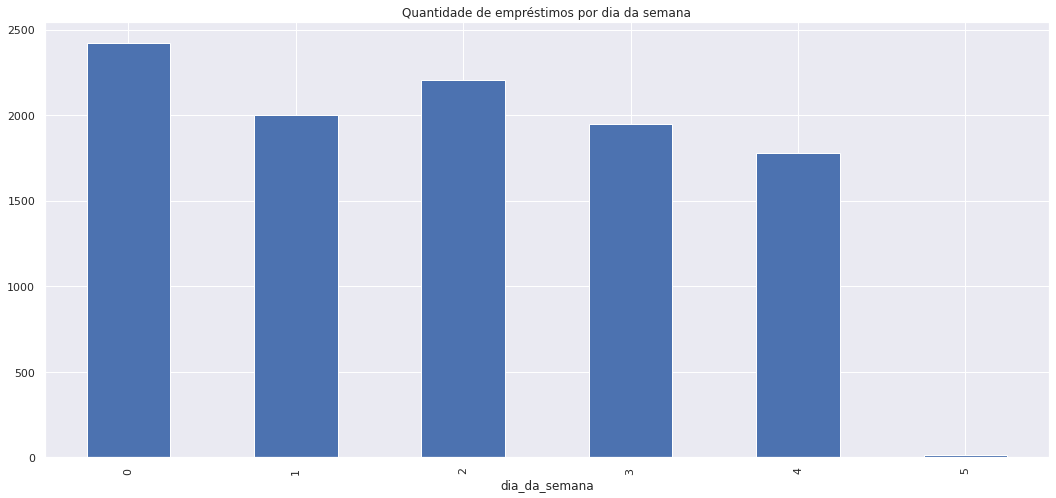

In [97]:
# Criar campo para o dia da semana
df7['dia_da_semana'] = df7['data_emprestimo'].dt.weekday

# Calcular a quantidade dos emprestimo por dia
df7.groupby('dia_da_semana').tombo.count().plot.bar(
    figsize=[18, 8], title='Quantidade de empréstimos por dia da semana')
print('')

In [98]:
emprestimo_por_dia_da_semana = df7.groupby('dia_da_semana').tombo.count().sort_values(ascending=False)

print("O dia com mais empréstimos foi na segunda-feira com {} empréstimos no total.".format(
    emprestimo_por_dia_da_semana.max()))

O dia com mais empréstimos foi na segunda-feira com 2421 empréstimos no total.


####  h9 - O mês do ano com mais empréstimo é junho

<font color=red> **FALSO:** O mês do ano com mais empréstimo é agosto;</font><br>

In [99]:
df8 = df7.copy()

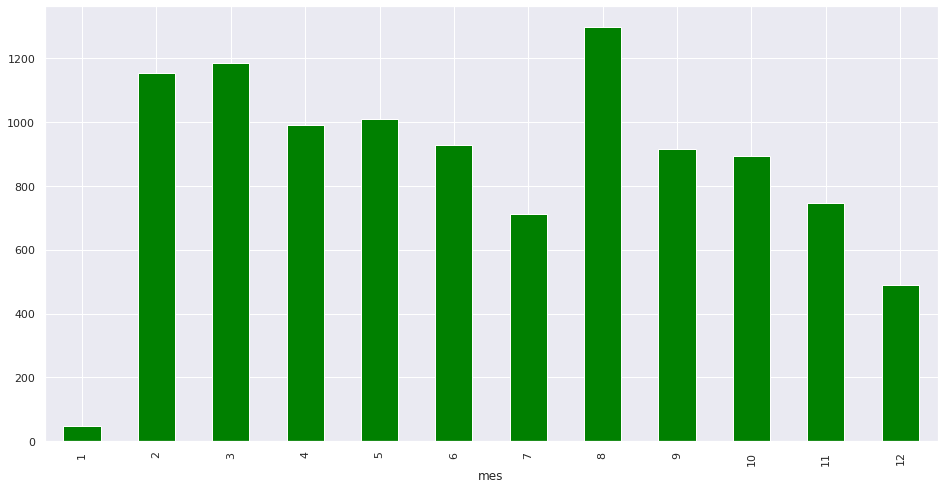

In [100]:
# Calcula a soma de empréstimos por mes
df8.groupby('mes').tombo.count().plot.bar(figsize=[16,8],color=['green'])
print('')

In [101]:
mes_mais_emprestimo = df8.groupby('mes').tombo.count().sort_values(ascending=False)


print("O mês com mais empréstimos foi agosto com {} empréstimos no total.".format(
  mes_mais_emprestimo.max()))

O mês com mais empréstimos foi agosto com 1297 empréstimos no total.


####  h10 - A média do valor das multas aplicadas por ano é superior à RS 1500,00.

<font color=green> ** VERDADEIRO: A média do valor das multas aplicadas por ano é de RS 2069,80.</font><br>

In [102]:
df9 = df8.copy()

In [103]:
valor_multa_anual = df9.groupby('ano').valor_multa.sum()
valor_multa_anual.reset_index
print('')

<AxesSubplot:title={'center':'Total de multas aplicadas por ano'}, xlabel='ano'>

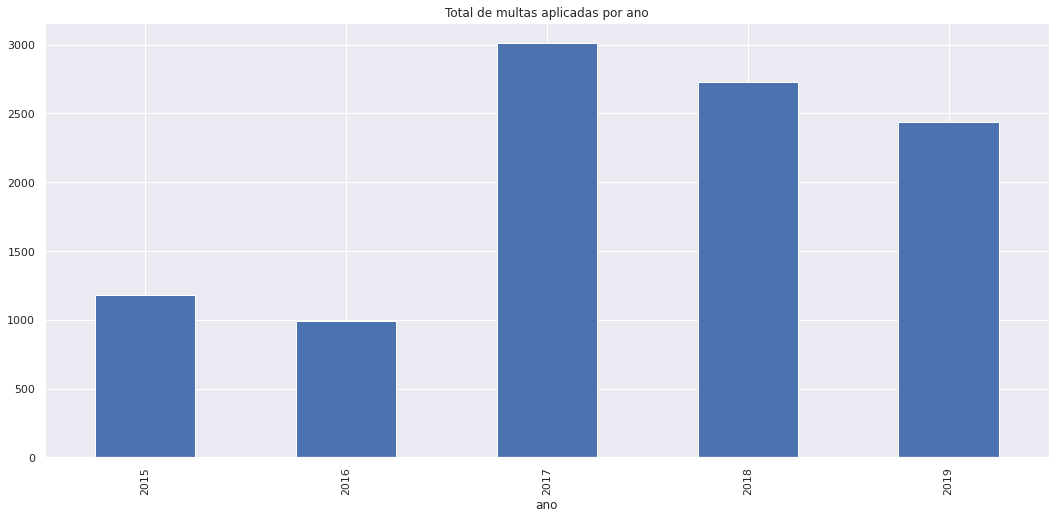

In [104]:
df9.groupby('ano').valor_multa.sum().plot.bar(figsize=[18,8], title='Total de multas aplicadas por ano')

#### h11 - Usuários do sexo M pagam em média 10% mais multas que os usuários do sexo F.

<font color='red'> ** FALSO: Usuários do sexo Masculino geraram duas vezes mais multas (em valor) que os usuários do sexo Feminino durante o período.</font>

In [105]:
df10 = df9.copy()

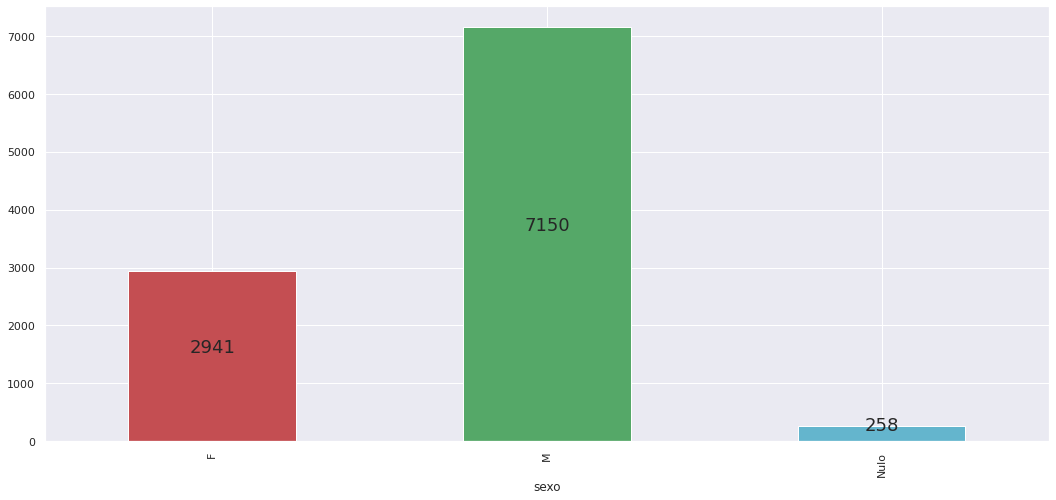

In [106]:
# Code to plot. Notice the variable ax.
ax = df10.groupby('sexo').valor_multa.sum().plot.bar(figsize=[18,8],color=['r','g','c'])

# Loop to add on each bar a tag in position
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize=18)

## Gerar dataset para modelo

In [107]:
# PARACATU
df10.to_csv('../datasets/processed/1-0-data-processed.csv')

# Próximos passos

- Apresentar os resultados (gerar novas hipóteses)
- Criar um modelo de previsão de quantos dias um livro doado deve ficar emprestado em um ano(mes?)
- Criar um modelo de previsão de empréstimos no próximo ano(?)
- Criar um modelo que classifica um livro novo a ser adicionado em probabilidade de ser usado (alta, média, baixa)